## Filter Method Example using Univariate Feature Selection

This notebook is an example of using univariate feature selection to improve classification accuracy on a noisy dataset.

Univariate feature selection works by selecting the best features based on univariate statistical tests. It can be seen as a preprocessing step to an estimator.

In this example, some noisy (non informative) features are added to the iris dataset. Support vector machine (SVM) is used to classify the dataset both before and after applying univariate feature selection. For each feature, we plot the p-values for the univariate feature selection and the corresponding weights of SVMs. With this, we will compare model accuracy and examine the impact of univariate feature selection on model weights.

In [7]:
import numpy as np

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

In [8]:
# The iris dataset
X, y = load_iris(return_X_y=True)

Add noisy data

In [9]:
# Some noisy data not correlated
E = np.random.RandomState(42).uniform(0, 0.1, size=(X.shape[0], 20))

# Add the noisy data to the informative features
X = np.hstack((X, E))

Split the data

In [10]:
# Split dataset to select feature and evaluate the classifier
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

Univariate feature selection with F-test for feature scoring. We use the default selection function to select the four most significant features.

In [11]:
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(f_classif, k=4)
selector.fit(X_train, y_train)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()

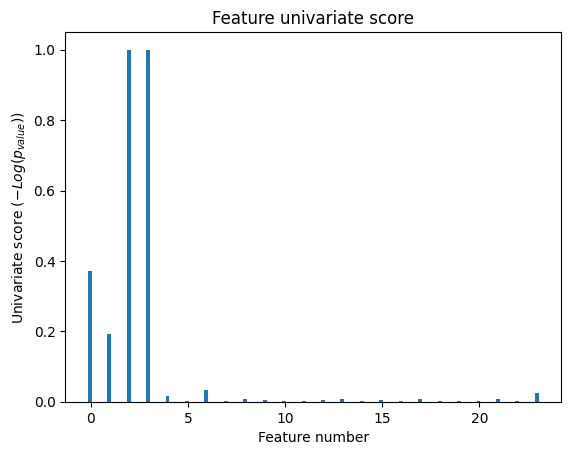

In [12]:
import matplotlib.pyplot as plt

X_indices = np.arange(X.shape[-1])
plt.figure(1)
plt.clf()
plt.bar(X_indices - 0.05, scores, width=0.2)
plt.title("Feature univariate score")
plt.xlabel("Feature number")
plt.ylabel(r"Univariate score ($-Log(p_{value})$)")
plt.show()

## Compare with SVMs

Without univariate feature selection

In [13]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import LinearSVC

clf = make_pipeline(MinMaxScaler(), LinearSVC())
clf.fit(X_train, y_train)
print(
    "Classification accuracy without selecting features: {:.3f}".format(
        clf.score(X_test, y_test)
    )
)

svm_weights = np.abs(clf[-1].coef_).sum(axis=0)
svm_weights /= svm_weights.sum()

Classification accuracy without selecting features: 0.789


After univariate feature selection

In [14]:
clf_selected = make_pipeline(SelectKBest(f_classif, k=4), MinMaxScaler(), LinearSVC())
clf_selected.fit(X_train, y_train)
print(
    "Classification accuracy after univariate feature selection: {:.3f}".format(
        clf_selected.score(X_test, y_test)
    )
)

svm_weights_selected = np.abs(clf_selected[-1].coef_).sum(axis=0)
svm_weights_selected /= svm_weights_selected.sum()

Classification accuracy after univariate feature selection: 0.868


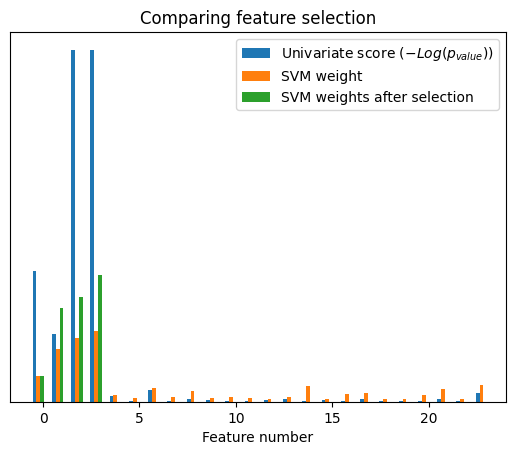

In [15]:
plt.bar(
    X_indices - 0.45, scores, width=0.2, label=r"Univariate score ($-Log(p_{value})$)"
)

plt.bar(X_indices - 0.25, svm_weights, width=0.2, label="SVM weight")

plt.bar(
    X_indices[selector.get_support()] - 0.05,
    svm_weights_selected,
    width=0.2,
    label="SVM weights after selection",
)

plt.title("Comparing feature selection")
plt.xlabel("Feature number")
plt.yticks(())
plt.axis("tight")
plt.legend(loc="upper right")
plt.show()

Without univariate feature selection, the SVM assigns a large weight to the first 4 original significant features, but also selects many of the non-informative features. Applying univariate feature selection before the SVM increases the SVM weight attributed to the significant features, and will thus improve classification.